In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scikit_posthocs as sp

%matplotlib inline

# Process diamond output

In [2]:
df = pd.read_csv("../gene_hits.tsv", header=0, index_col=None, sep="\t")

# drop the extra header cols
df = df[df["Query accession"]!="Query accession"]

# Create a sample id and read number columns from query accession 
df["Sample ID"] = df["Query accession"].apply(lambda x: x.split(".")[0])
df["Read number"] = df["Query accession"].apply(lambda x: x.split(".")[1])


## Remove where missing gene names

In [3]:
percent_with_names = sum(df["Gene name"].isna()==False)/df.shape[0]

print(round(percent_with_names*100), "percent of hits matched a gene name on uniprot")

# Only keep where we have a gene name
df = df[df["Gene name"].isna()==False]

42 percent of hits matched a gene name on uniprot


## Get metacyc gene names

In [4]:
pathway_1 = pd.read_csv("../database-building/metacyc-nic-deg-1.txt", 
                        header=1, sep="\t")
pathway_2 = pd.read_csv("../database-building/metacyc-nic-deg-2.txt", 
                        header=1, sep="\t")
pathway_3 = pd.read_csv("../database-building/metacyc-nic-deg-3.txt", 
                        header=1, sep="\t")

metacyc_gene_names = set(pathway_1["Gene name"]) | set(pathway_2["Gene name"]) | set(pathway_3["Gene name"])

## Remove where gene names not in metacyc pathways

In [5]:
df = df[df["Gene name"].apply(lambda x: x in metacyc_gene_names)]

In [6]:
df

,Unnamed: 0,Query accession,Target accession,Sequence identity,Length,Mismatches,Gap openings,Query start,Query end,Target start,Target end,E-value,Bit score,Gene name,Sample ID,Read number
1,1.0,SRR9641933.28440,tr|A0A3E2YTU4|A0A3E2YTU4_9ACTN,68.7,67,21,0,2,202,96,162,3.3e-20,92.8,nicF,SRR9641933,28440
5,5.0,SRR9641933.28440,tr|A0A0F0L0P7|A0A0F0L0P7_9MICO,50.0,64,32,0,8,199,118,181,4.7e-11,62.4,nicF,SRR9641933,28440
6,6.0,SRR9641933.28440,tr|A0A5P9IRS1|A0A5P9IRS1_9GAMM,56.9,58,20,1,26,199,111,163,1.8000000000000002e-10,60.5,nicF,SRR9641933,28440
7,7.0,SRR9641933.28440,tr|A0A165NIV5|A0A165NIV5_9RHOB,41.5,53,31,0,38,196,124,176,2.3e-05,43.5,nicF,SRR9641933,28440
8,8.0,SRR9641933.28440,tr|A0A165V9Q2|A0A165V9Q2_9RHOB,41.5,53,31,0,38,196,124,176,2.3e-05,43.5,nicF,SRR9641933,28440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541037,1474.0,SRR9641812.1131113,tr|A0A4R8QXP2|A0A4R8QXP2_9MYCO,42.6,47,27,0,144,4,336,382,4.8e-05,42.7,nicF,SRR9641812,1131113
541038,1475.0,SRR9641812.1131113,tr|A0A7W7UQY7|A0A7W7UQY7_9GAMM,43.5,46,25,1,138,4,353,398,6.3e-05,42.4,nicF,SRR9641812,1131113
541039,1476.0,SRR9641812.1131113,tr|A0A1S8P028|A0A1S8P028_CLOBE,29.0,69,40,2,180,1,326,394,6.3e-05,42.4,nicF,SRR9641812,1131113
541040,1477.0,SRR9641812.1136867,tr|A0A3S4UYK4|A0A3S4UYK4_9ACTO,86.1,36,5,0,108,1,188,223,1.3000000000000002e-10,60.1,nicF,SRR9641812,1136867


### Pick the best hit for each read

In [7]:
df["E-value"] = df["E-value"].astype(float)

In [8]:
df = df.loc[df.groupby("Query accession")["E-value"].idxmin()]

# Metadata

In [9]:
metadata = pd.read_csv("../metadata/metadata.csv")
metadata = metadata.set_index("#SampleID")

In [10]:
SRA1_metadata = pd.read_csv("../metadata/PRJNA508385_SRA_metadata.txt")
SRA2_metadata = pd.read_csv("../metadata/PRJNA548383_SRA_metadata.txt")

# This one was formatted really weirdly... csv in a tsv
SRA3_metadata_weird = pd.read_csv("../metadata/PRJNA544061_SRA_metadata.txt")
SRA3_metadata_data = [str(x) for x in SRA3_metadata_weird.index]
SRA3_metadata = [(x.split(",")[0][2:], x.split(",")[5]) for x in SRA3_metadata_data]
SRA3_metadata = pd.DataFrame(SRA3_metadata, columns=["Run","BioSample"])
SRA3_metadata = pd.concat([SRA3_metadata, SRA3_metadata_weird["Sample Name"].reset_index()],
                          axis=1)

# CHANGE THIS WE NEED SAMPLE NAME NOT BIOSAMPLE

SRA_metadata = pd.concat([SRA1_metadata[["Run","Sample Name"]],
                          SRA2_metadata[["Run","Sample Name"]],
                          SRA3_metadata[["Run","Sample Name"]]],
                        axis=0)
SRA_metadata = SRA_metadata.set_index("Sample Name")

In [11]:
metadata["Run"] = SRA_metadata["Run"]

# Get a count per sample

In [12]:
metadata = metadata.reset_index().set_index("Run")

In [13]:
metadata["Hits"] = df.groupby("Sample ID").count()["Query accession"]

In [14]:
metadata

,#SampleID,GroupName,Description,Age,Gender,Ethnicity,Duration of use,Frequency of use,Type of e-cig device,Nicotine concentration ( per milliliter of e-juice),Hits
Run,,,,,,,,,,,
SRR9641808,HNS126_S6,Never Smoker,HNS126_S6,28,Female,Caucasian,NaN,NaN,NaN,NaN,9.0
SRR9641805,HNS127_S7,Never Smoker,HNS127_S7,29,Male,Caucasian,NaN,NaN,NaN,NaN,3.0
SRR9641806,HNS128_S8,Never Smoker,HNS128_S8,23,Female,Caucasian,NaN,NaN,NaN,NaN,40.0
SRR9641807,HNS129_S9,Never Smoker,HNS129_S9,23,Female,Caucasian,NaN,NaN,NaN,NaN,15.0
SRR9641809,HNS130_S10,Never Smoker,HNS130_S10,25,Female,Caucasian,NaN,NaN,NaN,NaN,14.0
...,...,...,...,...,...,...,...,...,...,...,...
SRR9668722,D355_S41,ENDS Dual Smoker,D355_S41,20,Male,Caucasian,8 months,everyday,e-cig that use cartridges and disposable e-cig...,13 - 16 mg,19.0
SRR9668689,D356_S42,ENDS Dual Smoker,D356_S42,21,Female,Caucasian,3 months,everyday,e-cig that use cartridges,1.5 mg,59.0
SRR9668719,D357_S43,ENDS Dual Smoker,D357_S43,42,Female,Caucasian,1.5 years,everyday,Disposable coils,3 - 6 mg,27.0


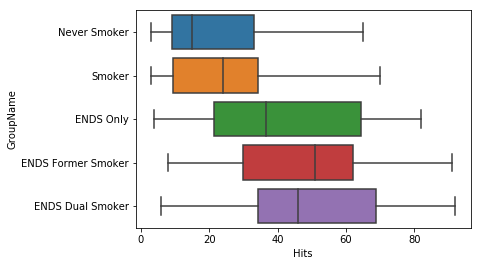

In [15]:
sns.boxplot("Hits",
            "GroupName",
            data=metadata)
plt.show()

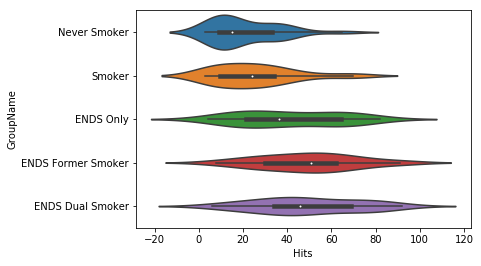

In [16]:
sns.violinplot("Hits",
            "GroupName",
            data=metadata)

In [17]:
never = metadata.loc[metadata["GroupName"]=="Never Smoker", "Hits"]
smoker = metadata.loc[metadata["GroupName"]=="Smoker", "Hits"]
ENDS = metadata.loc[metadata["GroupName"]=="ENDS Only", "Hits"]
ENDS_former = metadata.loc[metadata["GroupName"]=="ENDS Former Smoker", "Hits"]
ENDS_dual = metadata.loc[metadata["GroupName"]=="ENDS Dual Smoker", "Hits"]

In [18]:
stats.kruskal(never, smoker, ENDS, ENDS_former, ENDS_dual,
              nan_policy="omit")

KruskalResult(statistic=33.153771151758924, pvalue=1.1109435523674916e-06)

In [19]:
sp.posthoc_dunn(a=metadata, val_col="Hits", group_col="GroupName", 
                #p_adjust = 'holm'
               )

,ENDS Dual Smoker,ENDS Former Smoker,ENDS Only,Never Smoker,Smoker
ENDS Dual Smoker,1.000000,0.962242,0.284828,0.000013,0.000315
ENDS Former Smoker,0.962242,1.000000,0.276957,0.000018,0.000381
ENDS Only,0.284828,0.276957,1.000000,0.003072,0.022838
Never Smoker,0.000013,0.000018,0.003072,1.000000,0.486230
Smoker,0.000315,0.000381,0.022838,0.486230,1.000000


## Normalize for total reads
Have to do some cleaning bc I formatted poorly - will address later

In [20]:
with open("num_reads.txt") as f:
    contents = f.readlines()
contents = [content.strip().split("\\t") for content in contents]

In [21]:
num_reads_df = pd.DataFrame(contents, columns=["filepath", "num reads"])
num_reads_df = num_reads_df.replace("", np.NaN)
num_reads_df = num_reads_df[num_reads_df["num reads"].isna()==False]

In [22]:
num_reads_df["Sample"] = num_reads_df["filepath"].apply(lambda x: x.split("/")[-1].strip())
num_reads_df = num_reads_df.set_index("Sample")

In [23]:
metadata["Num reads"] = num_reads_df["num reads"].astype(int)

In [24]:
metadata["Hits per read"] = metadata["Hits"]/metadata["Num reads"]

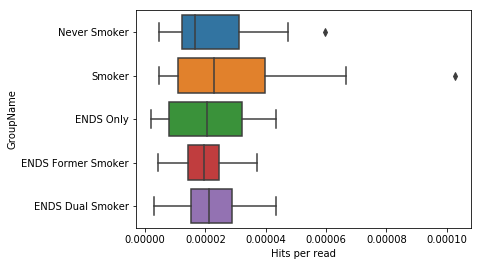

In [25]:
sns.boxplot("Hits per read",
            "GroupName",
            data=metadata)
plt.show()

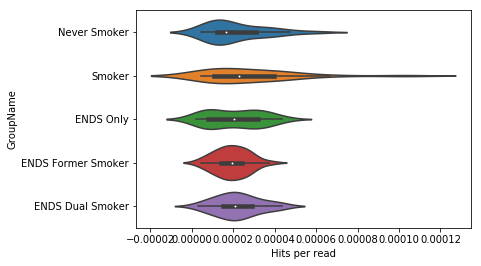

In [26]:
sns.violinplot("Hits per read",
            "GroupName",
            data=metadata)
plt.show()

In [27]:
never = metadata.loc[metadata["GroupName"]=="Never Smoker", "Hits per read"]
smoker = metadata.loc[metadata["GroupName"]=="Smoker", "Hits per read"]
ENDS = metadata.loc[metadata["GroupName"]=="ENDS Only", "Hits per read"]
ENDS_former = metadata.loc[metadata["GroupName"]=="ENDS Former Smoker", "Hits per read"]
ENDS_dual = metadata.loc[metadata["GroupName"]=="ENDS Dual Smoker", "Hits per read"]

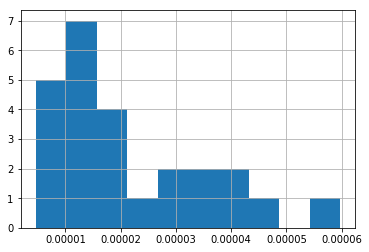

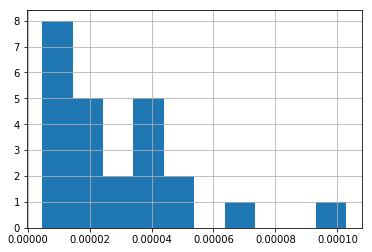

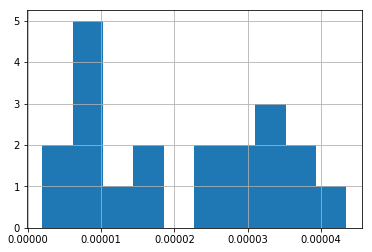

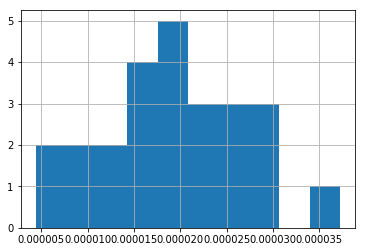

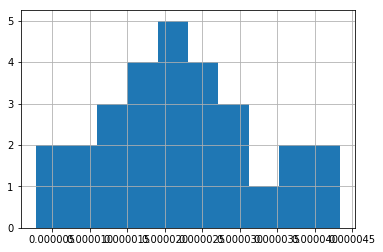

In [28]:
groups = [never, smoker, ENDS, ENDS_former, ENDS_dual]

for group in groups:
    group.hist()
    plt.show()

In [29]:
stats.kruskal(never, smoker, ENDS, ENDS_former, ENDS_dual,
              nan_policy="omit")

KruskalResult(statistic=1.7088777822204975, pvalue=0.7891043385389046)

In [30]:
names = metadata["GroupName"].unique()

pairwise_results_p = np.zeros(shape=(len(groups), len(groups)), )
pairwise_results_stat = np.zeros(shape=(len(groups), len(groups)))
for i, first_group in enumerate(groups):
    for j in range(i+1, len(groups)):
        second_group = groups[j]
        stat, p = stats.mannwhitneyu(first_group, second_group)
        pairwise_results_p[i,j] = p
        pairwise_results_stat[i,j] = stat

In [31]:
print("pvals")
pd.DataFrame(pairwise_results_p, index=names, columns=names)

pvals


,Never Smoker,Smoker,ENDS Only,ENDS Former Smoker,ENDS Dual Smoker
Never Smoker,0.0,0.147376,0.440986,0.461358,0.229825
Smoker,0.0,0.000000,0.124352,0.118291,0.246366
ENDS Only,0.0,0.000000,0.000000,0.396399,0.365028
ENDS Former Smoker,0.0,0.000000,0.000000,0.000000,0.188899
ENDS Dual Smoker,0.0,0.000000,0.000000,0.000000,0.000000


In [32]:
print("test statistic")
pd.DataFrame(pairwise_results_stat, index=names, columns=names)

test statistic


,Never Smoker,Smoker,ENDS Only,ENDS Former Smoker,ENDS Dual Smoker
Never Smoker,0.0,258.0,243.0,307.0,308.0
Smoker,0.0,0.0,199.0,251.0,311.0
ENDS Only,0.0,0.0,0.0,238.0,263.0
ENDS Former Smoker,0.0,0.0,0.0,0.0,300.0
ENDS Dual Smoker,0.0,0.0,0.0,0.0,0.0


In [33]:
sp.posthoc_dunn(a=metadata, val_col="Hits per read", group_col="GroupName", 
                #p_adjust = 'holm'
               )

,ENDS Dual Smoker,ENDS Former Smoker,ENDS Only,Never Smoker,Smoker
ENDS Dual Smoker,1.000000,0.461733,0.588291,0.520735,0.721000
ENDS Former Smoker,0.461733,1.000000,0.883295,0.927304,0.290834
ENDS Only,0.588291,0.883295,1.000000,0.951539,0.394458
Never Smoker,0.520735,0.927304,0.951539,1.000000,0.334048
Smoker,0.721000,0.290834,0.394458,0.334048,1.000000


In [34]:
print(metadata["Num reads"].min())
metadata["Num reads"].max()

225640.0


4262753.0

In [35]:
df

,Unnamed: 0,Query accession,Target accession,Sequence identity,Length,Mismatches,Gap openings,Query start,Query end,Target start,Target end,E-value,Bit score,Gene name,Sample ID,Read number
478850,117.0,SRR9641788.125477,tr|A0A4Y7R7Z6|A0A4Y7R7Z6_9FIRM,43.5,46,26,0,50,187,9,54,8.600000e-06,45.1,nicF,SRR9641788,125477
478860,127.0,SRR9641788.127907,tr|A0A132BQF3|A0A132BQF3_9RHOB,36.4,55,32,1,249,94,4,58,1.200000e-04,41.6,nicF,SRR9641788,127907
479011,278.0,SRR9641788.217120,tr|A0A7W5NI72|A0A7W5NI72_9BURK,31.8,85,58,0,257,3,359,443,2.000000e-07,50.8,nicF,SRR9641788,217120
479021,288.0,SRR9641788.219088,tr|A0A7W7C1R5|A0A7W7C1R5_9ACTN,32.4,71,44,1,206,6,314,384,3.300000e-04,40.0,pao,SRR9641788,219088
479023,290.0,SRR9641788.219755,tr|A0A1X9MND7|A0A1X9MND7_9BACI,68.6,51,15,1,153,4,2,52,1.100000e-14,74.7,pao,SRR9641788,219755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472432,747.0,SRR9668750.718706,tr|A0A009SNI0|A0A009SNI0_ACIBA,56.6,53,23,0,235,77,433,485,1.400000e-14,74.3,pao,SRR9668750,718706
472520,835.0,SRR9668750.758064,tr|A0A1S9GZQ4|A0A1S9GZQ4_9RHIZ,62.2,45,17,0,137,3,421,465,4.500000e-13,68.6,nicD,SRR9668750,758064
472554,869.0,SRR9668750.763174,tr|A0A377ZZA7|A0A377ZZA7_KLEPN,47.0,66,35,0,2,199,218,283,1.100000e-13,71.2,nicF,SRR9668750,763174
472792,1107.0,SRR9668750.958555,tr|A0A7X0BE53|A0A7X0BE53_9PSED,33.8,65,43,0,4,198,68,132,1.400000e-04,41.2,kdhC,SRR9668750,958555


In [36]:
df["Gene name"].unique()

array(['nicF', 'pao', 'mao', 'kdhB', 'ndhC', 'ndhB', 'kdhC', 'nboR',
       'sad', 'nicX', 'nicD', 'hspB', 'kdhA', 'maiA', 'nctB', 'ndhA'],
      dtype=object)

# Normalize by single copy genes

In [37]:
markers = pd.read_csv("../marker_gene_hits.tsv",  sep="\t", header=None, index_col=None)

In [38]:
markers.columns = ["Query accession", "Target accession", "Sequence identity", 
                   "Length", "Mismatches", "Gap openings","Query start", 
                   "Query end","Target start", "Target end", "E-value", "Bit score"]

Pick the top hit per Query accession

In [39]:
markers = markers.loc[markers.groupby("Query accession")["E-value"].idxmin()]

In [40]:
markers["Sample ID"] = markers["Query accession"].apply(lambda x: x.split(".")[0])

In [41]:
metadata["Marker genes"] = markers.groupby("Sample ID").count()["Query accession"]

In [42]:
metadata["Hits per marker gene"] = metadata["Hits"]/metadata["Marker genes"]

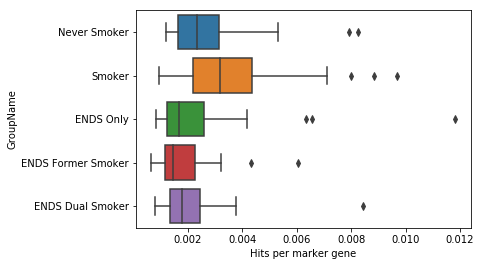

In [43]:
sns.boxplot("Hits per marker gene",
            "GroupName",
            data=metadata)
plt.show()

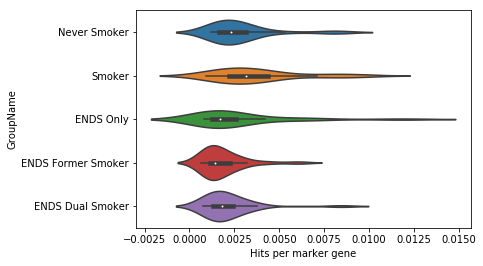

In [44]:
sns.violinplot("Hits per marker gene",
            "GroupName",
            data=metadata)
plt.show()

In [45]:
never = metadata.loc[metadata["GroupName"]=="Never Smoker", "Hits per marker gene"]
smoker = metadata.loc[metadata["GroupName"]=="Smoker", "Hits per marker gene"]
ENDS = metadata.loc[metadata["GroupName"]=="ENDS Only", "Hits per marker gene"]
ENDS_former = metadata.loc[metadata["GroupName"]=="ENDS Former Smoker", "Hits per marker gene"]
ENDS_dual = metadata.loc[metadata["GroupName"]=="ENDS Dual Smoker", "Hits per marker gene"]

print(stats.kruskal(never, smoker, ENDS, ENDS_former, ENDS_dual,
              nan_policy="omit"))

sp.posthoc_dunn(a=metadata, val_col="Hits", group_col="GroupName", 
                #p_adjust = 'holm'
               )

KruskalResult(statistic=18.39890691342515, pvalue=0.001031110068644959)


,ENDS Dual Smoker,ENDS Former Smoker,ENDS Only,Never Smoker,Smoker
ENDS Dual Smoker,1.000000,0.962242,0.284828,0.000013,0.000315
ENDS Former Smoker,0.962242,1.000000,0.276957,0.000018,0.000381
ENDS Only,0.284828,0.276957,1.000000,0.003072,0.022838
Never Smoker,0.000013,0.000018,0.003072,1.000000,0.486230
Smoker,0.000315,0.000381,0.022838,0.486230,1.000000


# What's going on with the normalization?

It seems like there are some outliers, which might be related to a low number of marker genes picked up in a sample. Could a low number of marker genes be indicative of low non-mammalian cell sampling?

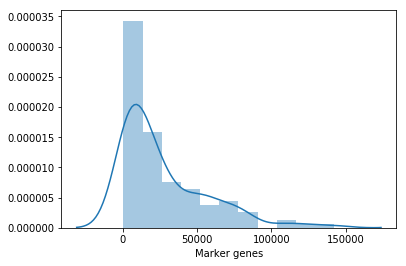

Min 364.0
Max 142333.0


In [46]:
sns.distplot(metadata["Marker genes"])
plt.show()

print("Min", metadata["Marker genes"].min())
print("Max", metadata["Marker genes"].max())

Looking at the plot below, there's a steep rise in number of hits recovered when marker genes are low, but this levels off as we cross the 10-15,000 reads threshold

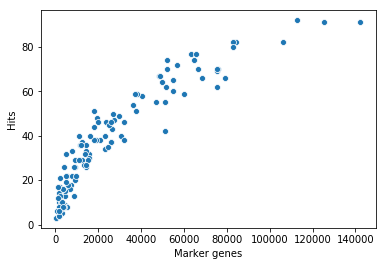

In [47]:
sns.scatterplot(x="Marker genes", y="Hits",
                data=metadata)
plt.show()

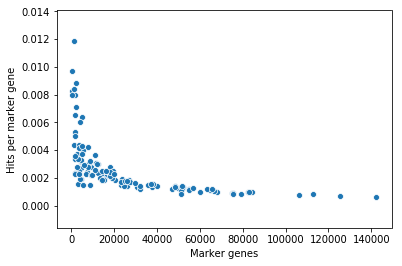

In [48]:
sns.scatterplot(x="Marker genes", y="Hits per marker gene",
                data=metadata)
plt.show()

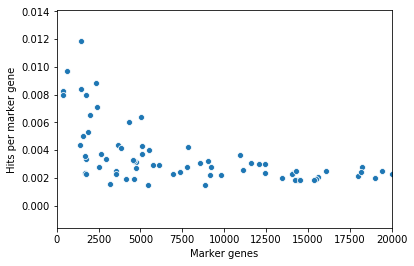

In [49]:
ax = sns.scatterplot(x="Marker genes", y="Hits per marker gene",
                    data=metadata)

ax.set_xlim(0,20000)
plt.show()

In [50]:
filtered_over = metadata[metadata["Marker genes"]>10000]
filtered_under = metadata[metadata["Marker genes"]<10000]

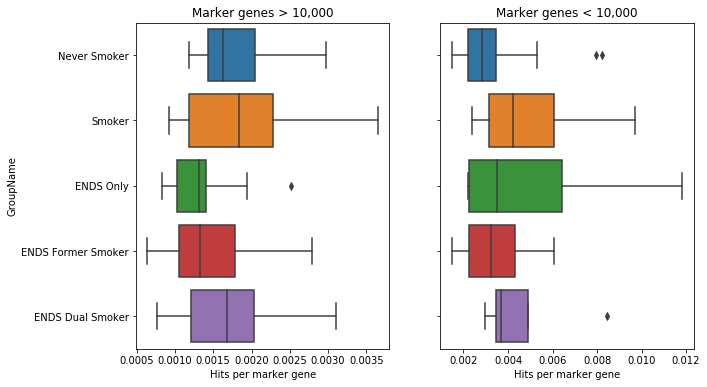

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

sns.boxplot("Hits per marker gene",
            "GroupName",
            data=filtered_over, ax=axes[0])
axes[0].set(title="Marker genes > 10,000")

sns.boxplot("Hits per marker gene",
            "GroupName",
            data=filtered_under, ax=axes[1])
axes[1].set(yticklabels=[], ylabel="", title="Marker genes < 10,000")
plt.show()

# How many of each gene?

In [52]:
df.shape

(4571, 16)

In [53]:
len(df["Query accession"].unique())

4571

In [54]:
by_gene = df.groupby("Gene name").count()["Query accession"]
by_gene.name = "Count"

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

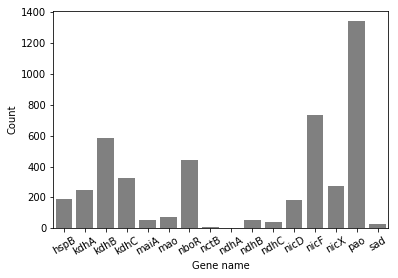

In [55]:
ax = sns.barplot(y=by_gene, 
                 x=by_gene.index,
                 palette=["gray"])
plt.xticks(rotation=30)

In [56]:
by_gene_pathway =pd.Series(["pyrrolidine",
                      "pyridine",
                      "pyridine",
                      "pyridine",
                      "pyrrolidine",
                      "pyridine",
                      "pyridine",
                      "pyridine",
                      "pyridine",
                      "pyridine",
                      "pyridine",
                      "pyrrolidine",
                      "pyrrolidine",
                      "pyrrolidine",
                      "pyrrolidine",
                      "pyridine"], index=by_gene.index)

by_gene_df = pd.concat([by_gene, by_gene_pathway],
                    axis=1)
by_gene_df.columns = ["Count", "Pathway"]

In [57]:
by_gene_df = by_gene_df.sort_values(by="Pathway")

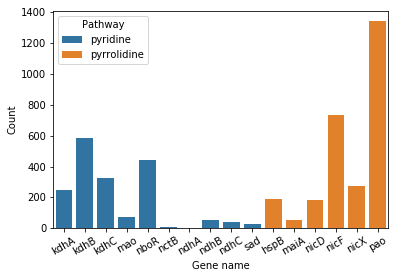

In [58]:
sns.barplot(x=by_gene_df.index,
            y=by_gene_df["Count"],
            hue=by_gene_df["Pathway"],
            dodge=False)
plt.xticks(rotation=30)
plt.show()

# Which genes in negative control?

In [59]:
e_coli = pd.read_csv("../organisms/E_coli_nic_diamond_mapped.tsv", sep="\t")
e_coli["Gene name"].value_counts()

gabD                  21
EG356c_098             1
EWT59_22830            1
MCHUDSM44219_01503     1
KGOCCACH_00361         1
MCHLDSM_02244          1
yieA                   1
BFL24_18940            1
CCUG60885_01036        1
Name: Gene name, dtype: int64

looks like we're mostly only picking up gabd in e coli but not in our data

In [60]:
gene_pathway_dict = by_gene_pathway.to_dict()
df["gene pathway"] = df["Gene name"].apply(lambda x: gene_pathway_dict[x])
metadata["pyrrolidine hits"] = df.loc[df["gene pathway"]=="pyrrolidine"].groupby("Sample ID").count()["Query accession"]
metadata["pyridine hits"] = df.loc[df["gene pathway"]=="pyridine"].groupby("Sample ID").count()["Query accession"]

In [61]:
metadata["pyridine hits per read"] = metadata["pyridine hits"]/metadata["Num reads"]
metadata["pyrrolidine hits per read"] = metadata["pyrrolidine hits"]/metadata["Num reads"]

metadata["pyridine hits per marker gene"] = metadata["pyridine hits"]/metadata["Marker genes"]
metadata["pyrrolidine hits per marker gene"] = metadata["pyrrolidine hits"]/metadata["Marker genes"]

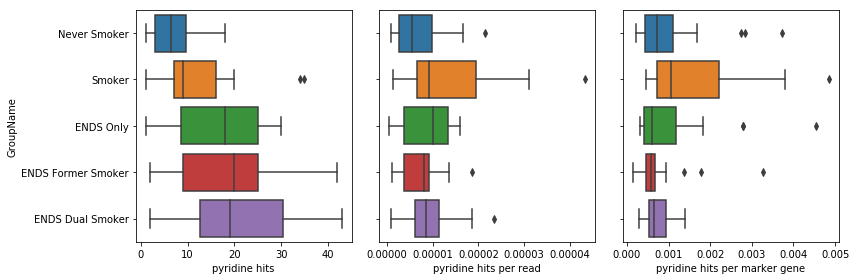

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i, label in enumerate(["pyridine hits", "pyridine hits per read", "pyridine hits per marker gene"]):
    sns.boxplot(x=label, y="GroupName",
                data=metadata, 
                ax=axes[i])
    if i>0:
        axes[i].set(yticklabels=[], ylabel="")
plt.tight_layout()
plt.show()

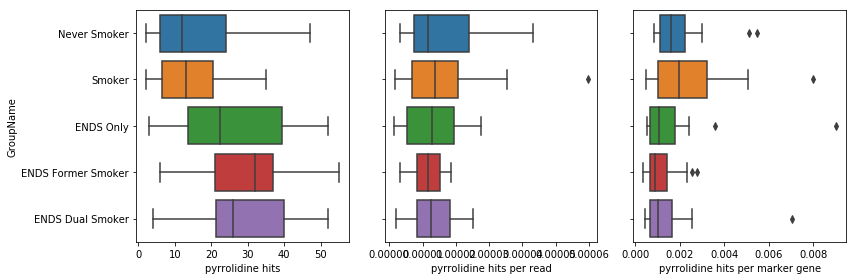

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i, label in enumerate(["pyrrolidine hits", "pyrrolidine hits per read", "pyrrolidine hits per marker gene"]):
    sns.boxplot(x=label, y="GroupName",
                data=metadata, 
                ax=axes[i])
    if i>0:
        axes[i].set(yticklabels=[], ylabel="")
plt.tight_layout()
plt.show()

# What about the most direct genes?

"Direct genes" includes genes involved in the first 3 reactions in both pathways. "Most direct genes" only counts the first reaction - this only included ndhA/B/C in this dataset.

In [64]:
by_gene.index

Index(['hspB', 'kdhA', 'kdhB', 'kdhC', 'maiA', 'mao', 'nboR', 'nctB', 'ndhA',
       'ndhB', 'ndhC', 'nicD', 'nicF', 'nicX', 'pao', 'sad'],
      dtype='object', name='Gene name')

In [66]:
direct_genes_dict = {
    'hspB': False, 
    'kdhA': True, 'kdhB': True, 'kdhC': True, 
    'maiA': False, 'mao': False, 'nboR': False, 'nctB': False, 
    'ndhA': True, 'ndhB': True, 'ndhC': True, 'pao': True, 
    'nicD': False, 'nicF': False, 'nicX': False, 'sad': False
}

df["direct"] = df["Gene name"].apply(lambda x: direct_genes_dict[x])
metadata["direct hits"] = df.loc[df["direct"]==True].groupby("Sample ID").count()["Query accession"]

metadata["direct hits per read"] = metadata["direct hits"]/metadata["Num reads"]

metadata["direct hits per marker gene"] = metadata["direct hits"]/metadata["Marker genes"]

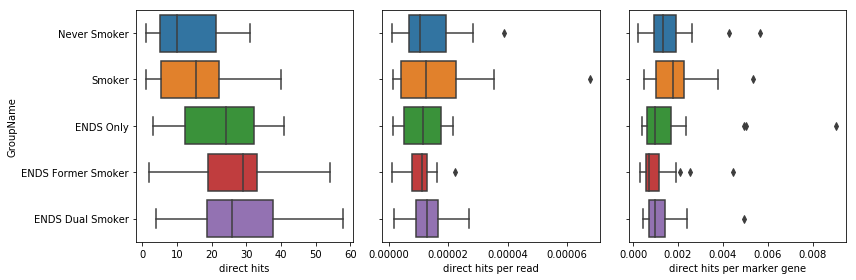

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i, label in enumerate(["direct hits", "direct hits per read", "direct hits per marker gene"]):
    sns.boxplot(x=label, y="GroupName",
                data=metadata, 
                ax=axes[i])
    if i>0:
        axes[i].set(yticklabels=[], ylabel="")
plt.tight_layout()
plt.show()

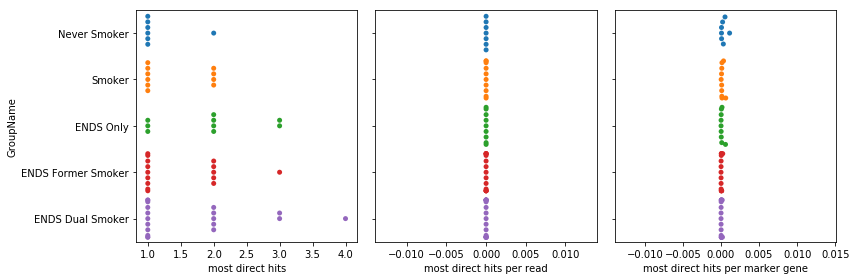

In [70]:
most_direct_genes_dict = {
    'hspB': False, 
    'kdhA': False, 'kdhB': False, 'kdhC': False, 
    'maiA': False, 'mao': False, 'nboR': False, 'nctB': False, 
    'ndhA': True, 'ndhB': True, 'ndhC': True, 'pao': False, 
    'nicD': False, 'nicF': False, 'nicX': False, 'sad': False
}

df["most direct"] = df["Gene name"].apply(lambda x: most_direct_genes_dict[x])
metadata["most direct hits"] = df.loc[df["most direct"]==True].groupby("Sample ID").count()["Query accession"]

metadata["most direct hits per read"] = metadata["most direct hits"]/metadata["Num reads"]

metadata["most direct hits per marker gene"] = metadata["most direct hits"]/metadata["Marker genes"]

fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i, label in enumerate(["most direct hits", "most direct hits per read", "most direct hits per marker gene"]):
    sns.swarmplot(x=label, y="GroupName",
                data=metadata, 
                ax=axes[i])
    if i>0:
        axes[i].set(yticklabels=[], ylabel="")
plt.tight_layout()
plt.show()